# Adapt the optimized 3D MTSE for the MaRCoS system (Optional)
The small MaRCoS system has certain hardware limitations:
1. Due to hardware imperfections, MaRCoS requires additional buffer areas (e.g. an additional flattop of 500e-6 s) on the flat top of the read gradient before and after the 'sampling_time'.
2. 10 ADC samples prior to the 'sampling_time' are required to initialize decimation filters.
3. 10 ADC samples after the 'sampling_time' are required for decimation filters.
4. An oversampling factor of 6 is required for ADC.
**Exercise**           
Bonus question: In order to run 3D MTSE on MaRCoS, could you please try to adapt it to satisfy the MaRCoS' hardware limitations?

#Sequence definition
* Simulation with Pulseq interpreter
* load mtse
* nothing esle to do?
* 3D -> gpu needed, or single slice

New System:
quantitative maps
quantalizer

New sequence:
take mtse

Explore values:
sliders
add noise
lower flip angles
remove spoilers
change 90s TE2 -> phase
switch onoff gradients

phantom:
increase B0 and B1 inhom
T1 to inf -> decay
single point -> psf analysis

potential:
traps opt in pulseq zero
recon as bloch model / learning

# Setup of Simulation
*  Load pulseq sequence from Freiburg
*  Design a realistic low field phantom
*  Load the phantom and simulate
* Reduce 3D dim

# Only in simulation
*  spoiler too weak?
*  timing wrong?
*  phase investigations
*  forgot phase cycling
*  T1 influence on T2 map
*  B1 influence on T2 map
*  Diffusion affects T2
*  Pulse sim + offres

* 3.05 MhZ * 4000 ppm = 12000 Hz




In [1]:
#@title 3D MTSE forMaRCoS in a brain phantom - environment setup (just need to run it one time)
!pip show pypulseq || pip install pypulseq &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as pp
# for simulation
!pip show MRzeroCore || pip install MRzeroCore
import MRzeroCore as mr0
import torch
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!wget https://github.com/mzaiss/MRTwin_pulseq/raw/mr0-core/data/low_field_phantom.mat &> /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 5.1 MB/s eta 0:00:00


TR fill: 232.52000000000004 ms


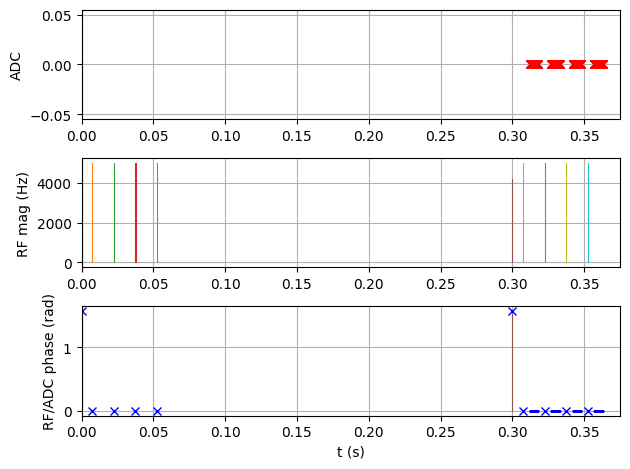

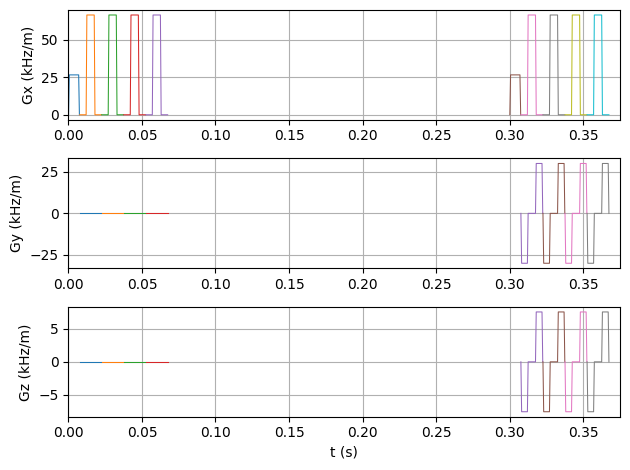

desired TE= 0.015000000000000001  realized TE= 0.01500833333333329  error of TE= 8.333333333289047e-06  t_ref-t_ex= 0.007500000000000007
Echo Spacing= 0.015000000000000003  error of ESP= 1.734723475976807e-18
desired TR= 0.3  achieved TR= 0.30000000000000004  error of TR= 5.551115123125783e-17


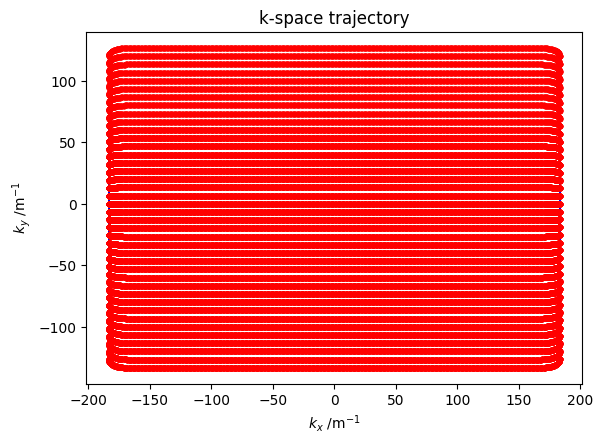

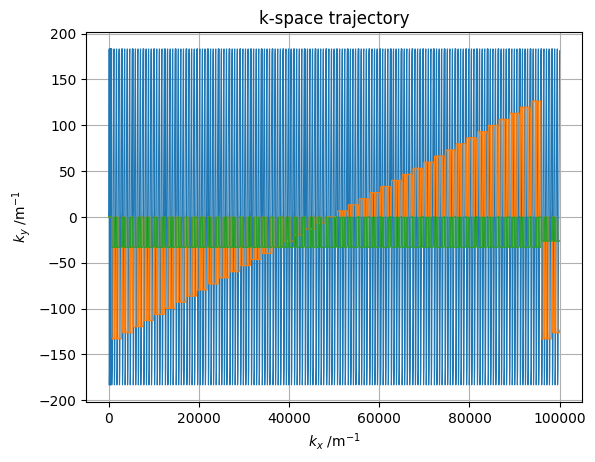

In [2]:
  #@title 3D MTSE for MaRCoS - sequence
# %% SETUP system
  # choose the scanner limits
system = pp.Opts(
        max_grad=25,       # MaRCoS's limits are 25, 40 and 35 mT/m for X, Y and Z axes
        grad_unit="mT/m",
        max_slew=50,       # MaRCoS's limits are 50, 80 and 70 mT/m/ms for X, Y and Z, respectively
        slew_unit="T/m/s",
        rf_ringdown_time=15e-6,
        rf_dead_time=15e-6,
        adc_dead_time=0e-6 )


def create_mtse(
    FAex=90,
    FAref=180,
    fsp_r=1,
    fov_mm=(150, 150, 150),
    nRD=40,
    nPH=40,
    n3D=10,
    n_echo=4,
    TE=15e-3,
    TR=300e-3,
    rdGradTime=5e-3,
    acqTime=4e-3,
    dG=500e-6,
    sampling_time=None,
    rd_flattop_add=None,
    nRD_pre=10,
    nRD_post=None,
    os=6,
    t_ex=60e-6,
    t_ref=100e-6,
    rf_ex_phase=np.pi/2,
    rf_ref_phase = 0, # phase of the refocusing pulse
    time_range=(0,0.375)
):
    if sampling_time is None:
        sampling_time = acqTime
    if rd_flattop_add is None:
        rd_flattop_add = (rdGradTime - acqTime) / 2
    if nRD_post is None:
        nRD_post = nRD_pre

    # Create a new sequence object, needed for definitions
    seq = pp.Sequence(system)


    # derived and modifed parameters
    fov = np.array(fov_mm) * 1e-3 # FOV in meters
    TE = round(TE/system.grad_raster_time/2) * system.grad_raster_time * 2 # TE (=ESP) should be divisible to a double gradient raster, which simplifies calcuations
    rd_flattop_time = sampling_time + 2*rd_flattop_add ; # duration of the flat top of the read gradient
    rf_add = math.ceil(max(system.rf_dead_time,system.rf_ringdown_time)/system.grad_raster_time)*system.grad_raster_time # round up dead times to the gradient raster time to enable correct TE & ESP calculation
    t_sp = round((0.5 * (TE - rd_flattop_time - t_ref) - rf_add)/system.grad_raster_time)*system.grad_raster_time # the duration of gradient spoiler after the refocusing pulse
    t_spex = round((0.5 * (TE - t_ex - t_ref) - 2*rf_add)/system.grad_raster_time)*system.grad_raster_time # the duration of readout prephaser after the excitation pulse. note: exclude the RF ringdown time of excitation pulse and rf dead time of refocusing pulse

    # ======
    # CREATE EVENTS
    # ======
    # excitation and refocusing pulses
    flip_ex = FAex * np.pi / 180
    rf_ex = pp.make_block_pulse(
        flip_angle=flip_ex,
        system=system,
        duration=t_ex,
        delay=rf_add,
        phase_offset=rf_ex_phase )

    d_ex=pp.make_delay(t_ex+rf_add*2)

    flip_ref = FAref * np.pi / 180
    rf_ref = pp.make_block_pulse(
        flip_angle=flip_ref,
        system=system,
        duration=t_ref,
        delay=rf_add,
        phase_offset=rf_ref_phase,
        use="refocusing" )

    d_ref=pp.make_delay(t_ref+rf_add*2)

    delta_kx = 1 / fov[0]
    rd_amp = nRD * delta_kx / sampling_time

    gr_acq = pp.make_trapezoid(
        channel="x",
        system=system,
        amplitude = rd_amp,
        flat_time=rd_flattop_time,
        delay=t_sp,
        rise_time=dG )

    adc = pp.make_adc(
        num_samples=(nRD_pre+nRD+nRD_post)*os,
        dwell=sampling_time/nRD/os,
        delay=t_sp+dG-nRD_pre*sampling_time/nRD ) # nRD_pre*sampling_time/nRD: delay for additional ADC samples to initialize decimation filters prior to the 'sampling_time'

    gr_spr = pp.make_trapezoid(
        channel="x",
        system=system,
        area=gr_acq.area * fsp_r,
        duration=t_sp,
        rise_time=dG ) # qc: why spoiler in readout direction?

    agr_spr = gr_spr.area
    agr_preph = gr_acq.area / 2 + agr_spr # readout prephaser: account for readout pre-spoiler and readout gradient
    gr_preph = pp.make_trapezoid(
        channel="x", system=system, area=agr_preph, duration=t_spex, rise_time=dG )

    # Phase-encoding
    delta_ky = 1 / fov[1]
    gp_max = pp.make_trapezoid(
                    channel="y",
                    system=system,
                    area=delta_ky*nPH/2,
                    duration=t_sp,
                    rise_time=dG )

    # Partition encoding
    delta_kz = 1 / fov[2]
    gs_max = pp.make_trapezoid(
                    channel="z",
                    system=system,
                    area=delta_kz*n3D/2,
                    duration=t_sp,
                    rise_time=dG )
    # combine parts of the read gradient
    gc_times = np.array(
        [
            0,
            gr_spr.rise_time,
            gr_spr.flat_time,
            gr_spr.fall_time,
            gr_acq.flat_time,
            gr_spr.fall_time,
            gr_spr.flat_time,
            gr_spr.rise_time ] )
    gc_times = np.cumsum(gc_times)

    gr_amp = np.array([0, gr_spr.amplitude, gr_spr.amplitude, gr_acq.amplitude, gr_acq.amplitude, gr_spr.amplitude, gr_spr.amplitude, 0])
    gr = pp.make_extended_trapezoid(channel="x", times=gc_times, amplitudes=gr_amp)

    gp_amp = np.array([0, gp_max.amplitude, gp_max.amplitude, 0, 0, -gp_max.amplitude, -gp_max.amplitude, 0])
    gp_max = pp.make_extended_trapezoid(channel="y", times=gc_times, amplitudes=gp_amp)

    gs_amp = np.array([0, gs_max.amplitude, gs_max.amplitude, 0, 0, -gs_max.amplitude, -gs_max.amplitude, 0])
    gs_max = pp.make_extended_trapezoid(channel="z", times=gc_times, amplitudes=gs_amp)

    # Fill-times
    t_ex = pp.calc_duration(d_ex) + pp.calc_duration(gr_preph)
    t_ref = pp.calc_duration(d_ref) + pp.calc_duration(gr)

    t_train = t_ex + n_echo * t_ref

    TR_fill = TR - t_train
    # Round to gradient raster
    TR_fill = system.grad_raster_time * np.round(TR_fill / system.grad_raster_time)
    if TR_fill < 0:
        TR_fill = 1e-3
        warnings.warn(
            f"TR too short, adapted to: {1000 * (t_train + TR_fill)} ms"
        )
    else:
        print(f"TR fill: {1000 * TR_fill} ms")
    delay_TR = pp.make_delay(TR_fill)

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    for Cz in range(-1,n3D):
        if Cz >= 0:
            sl_scale = (Cz-n3D/2)/n3D*2; # from -1 to +1
            nPH_range=range(nPH)
        else:
            sl_scale = 0.0
            nPH_range=range(1) # skip the nPH loop for dummy scan(s)

        gs=pp.scale_grad(gs_max, sl_scale)

        for Cy in nPH_range:
            seq.add_block(rf_ex, d_ex)
            seq.add_block(gr_preph)

            if Cz >= 0:
                pe_scale = (Cy-nPH/2)/nPH*2; # from -1 to 1
            else:
                pe_scale = 0.0

            gp=pp.scale_grad(gp_max, pe_scale)

            for k_echo in range(n_echo):

                seq.add_block(rf_ref, d_ref)
                if Cz >= 0:
                    seq.add_block(gs, gp, gr, adc)
                else:
                    seq.add_block(gs, gp, gr)

            seq.add_block(delay_TR)

    # (ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
    # if ok:
    #     print("Timing check passed successfully")
    # else:
    #     print("Timing check failed. Error listing follows:")
    #     [print(e) for e in error_report]

    # ======
    # VISUALIZATION
    # ======
    seq.plot(time_range=time_range)

    [k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc] = seq.calculate_kspace() #(gradient_offset=(3000,-2000,2000))

    t_adc_echo=t_adc[round((nRD_pre+nRD+nRD_post)*os/2)] # the center of the first echo
    n_ex_echo=np.where(t_excitation<t_adc_echo)[0][-1] # n_ex_echo = 1
    n_ref_echo=np.where(t_refocusing<t_adc_echo)[0][-1] # n_ref_echo = 4
    print("desired TE=",TE,
          " realized TE=", t_adc_echo-t_excitation[n_ex_echo],
          " error of TE=", t_adc_echo-t_excitation[n_ex_echo]-TE,
          " t_ref-t_ex=", t_refocusing[n_ref_echo]-t_excitation[n_ex_echo])
    print("Echo Spacing=", t_refocusing[1]-t_refocusing[0],
          " error of ESP=", t_refocusing[1]-t_refocusing[0]-TE)
    print("desired TR=", TR,
          " achieved TR=", t_excitation[1]-t_excitation[0],
          " error of TR=", t_excitation[1]-t_excitation[0]-TR)

    n1 = 100000
    n2 = 100000
    plt.figure()
    plt.plot(k_traj[0,0:n1],k_traj[1,0:n1], 'b-')
    plt.plot(k_traj_adc[0,0:n2],k_traj_adc[1,0:n2], 'r.')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.title('k-space trajectory')
    plt.xlabel(r'$k_x \mathregular{\ /m^{-1}}$')
    plt.ylabel(r'$k_y \mathregular{\ /m^{-1}}$')
    plt.show()

    plt.figure()
    plt.plot(k_traj[0,0:n1])
    plt.plot(k_traj[1,0:n1])
    plt.plot(k_traj[2,0:n1])
    ax = plt.gca()
    ax.grid();
    plt.title('k-space trajectory')
    plt.xlabel(r'$k_x \mathregular{\ /m^{-1}}$')
    plt.ylabel(r'$k_y \mathregular{\ /m^{-1}}$')
    plt.show()

    # Prepare the sequence output for the scanner
    seq.write('external.seq')

    return seq

create_mtse(fsp_r=0)


TR fill: 232.52000000000004 ms


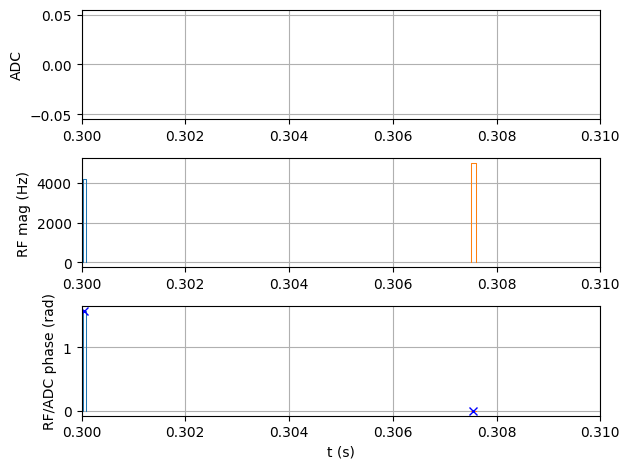

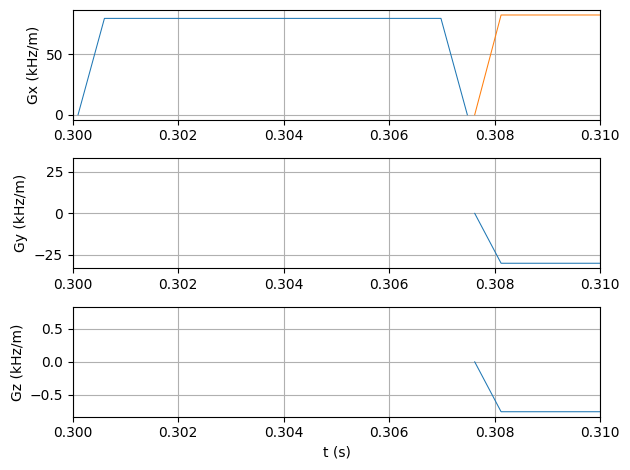

desired TE= 0.015000000000000001  realized TE= 0.01500833333333329  error of TE= 8.333333333289047e-06  t_ref-t_ex= 0.007500000000000007
Echo Spacing= 0.015000000000000003  error of ESP= 1.734723475976807e-18
desired TR= 0.3  achieved TR= 0.30000000000000004  error of TR= 5.551115123125783e-17


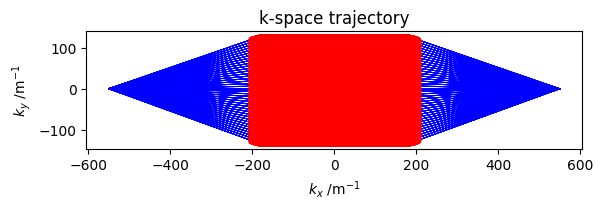

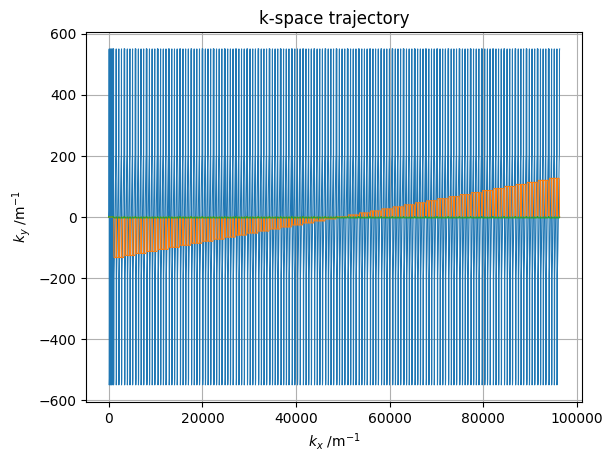

In [3]:
#@title 3D MTSE forMaRCoS in a brain phantom - sequence
FAex = 90 #@param {type:"slider", min:1, max:90, step:1}
FAref = 180 #@param {type:"slider", min:1, max:180, step:1}
fsp_r = 1 #@param {type:"slider", min:0, max:3, step:0.1}
fov_x =  150#param {type:"integer"}
fov_y =  150#param {type:"integer"}
fov_z =  150#param {type:"integer"}
nRD =  40#param {type:"slider", min:0, max:80, step:1}
nPH =  40#param {type:"slider", min:0, max:80, step:1}
n3D =  1#@param {type:"slider", min:0, max:20, step:1}
n_echo =  4#@param {type:"slider", min:0, max:8, step:1}
TE =  15e-3#@param {type:"number"}
TR =  300e-3#@param {type:"number"}
rdGradTime =  5e-3 #param {type:"number"}
acqTime = 4e-3 #param {type:"number"}
dG = 500e-6 #param {type:"number"}
sampling_time =  4e-3#param {type:"number"}
rd_flattop_add =  0.5e-3#param {type:"number"}
nRD_pre =  10#param {type:"slider", min:0, max:20, step:1}
nRD_post =  10#param {type:"slider", min:0, max:20, step:1}
os =  6#param {type:"slider", min:0, max:12, step:1}
t_ex =  60e-6#param {type:"number"}
t_ref =  100e-6#param {type:"number"}
rf_ex_phase =  90 #@param {type:"slider", min:0, max:180, step:45}
rf_ex_phase*=np.pi/180
rf_ref_phase =  0 #param {type:"slider", min:0, max:180, step:45}
rf_ref_phase*=np.pi/180
t0=0.3 #@param {type:"number"}
t1=0.31 #@param {type:"number"}
seq=create_mtse(FAex=FAex,FAref=FAref,fsp_r=fsp_r, fov_mm=(fov_x, fov_y, fov_z), nRD=nRD, nPH=nPH, n3D=n3D, n_echo=n_echo, TE=TE, TR=TR, rdGradTime=rdGradTime, acqTime=acqTime, dG=dG, sampling_time=sampling_time, rd_flattop_add=rd_flattop_add, nRD_pre=nRD_pre, nRD_post=nRD_post, os=os, t_ex=t_ex, t_ref=t_ref, rf_ex_phase=rf_ex_phase, rf_ref_phase = rf_ref_phase,time_range=(t0, t1))

VoxelGridPhantom
size = tensor([0.1500, 0.1500, 0.1500])
Plotting slice 2 / 4


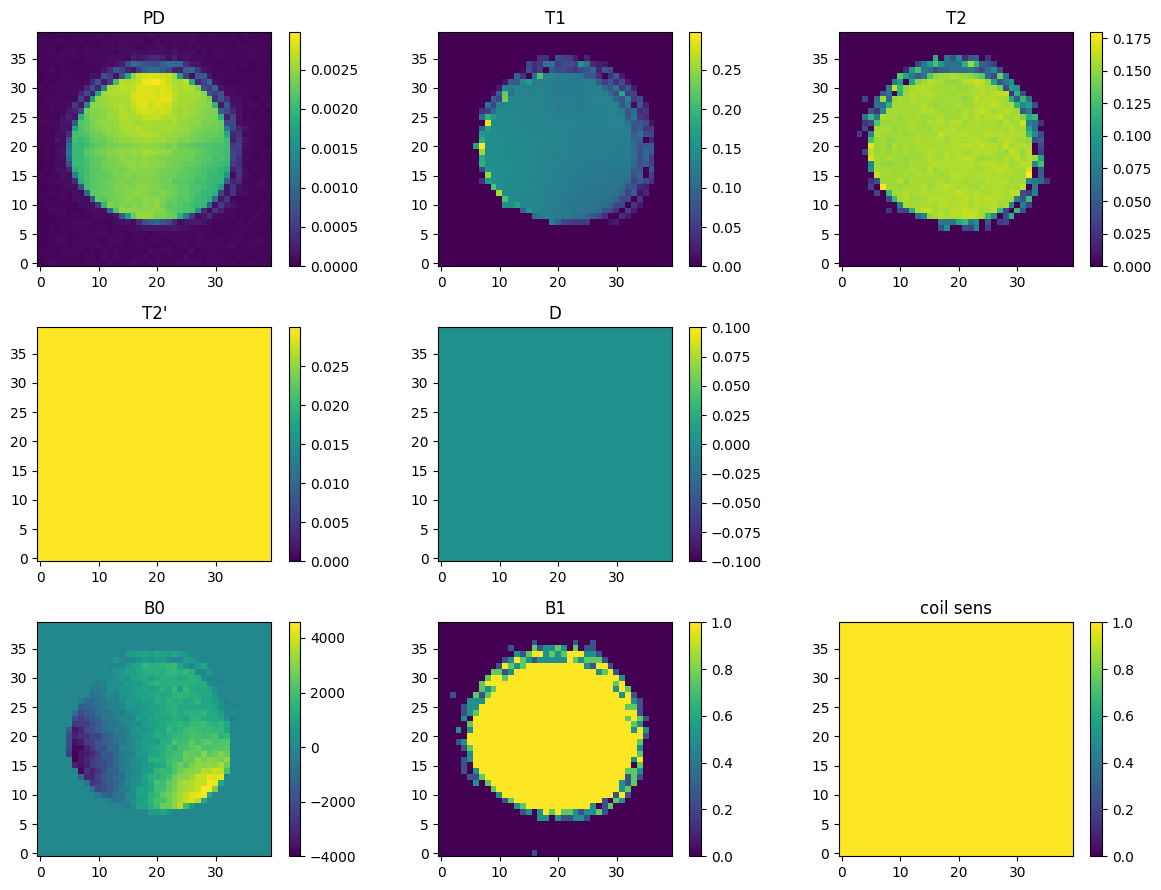

Calculating repetition 205 / 205 - done


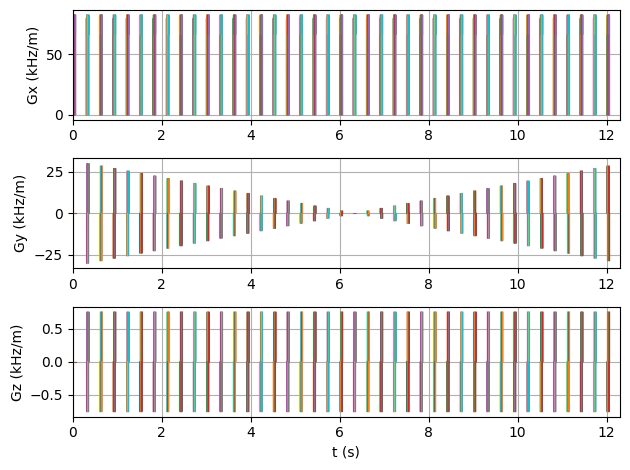

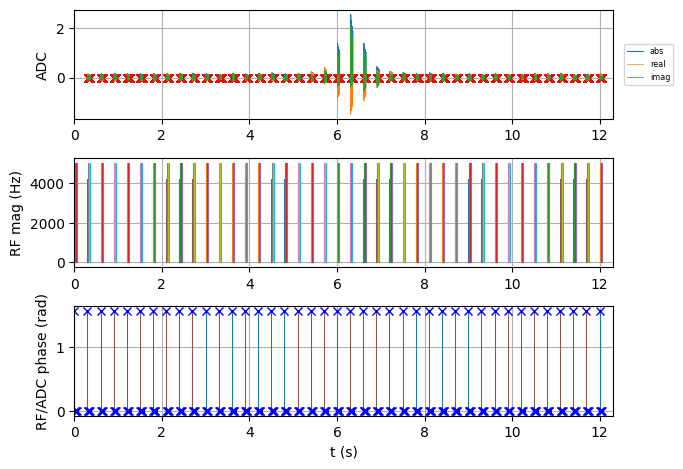

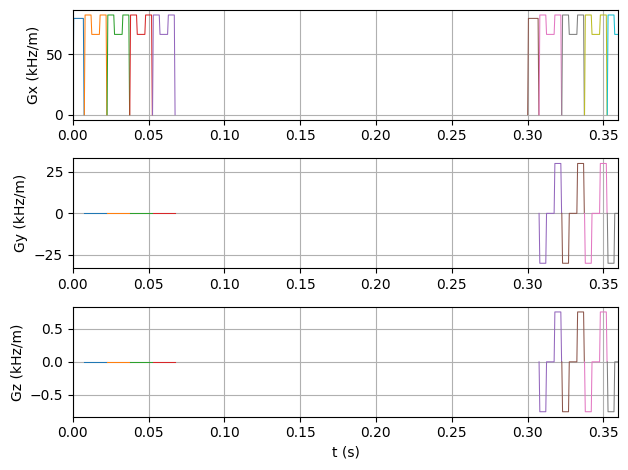

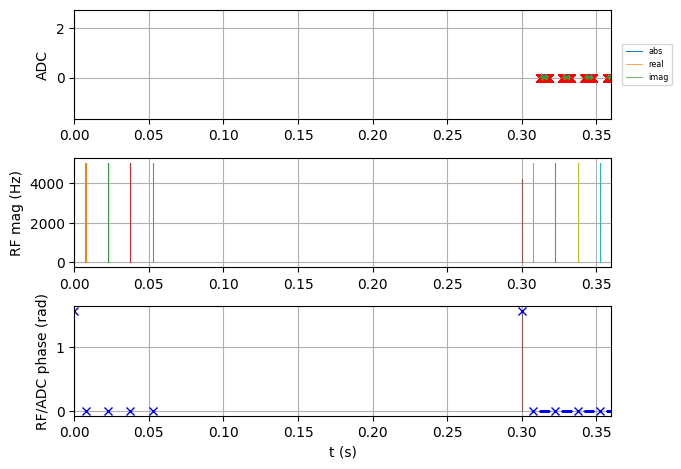

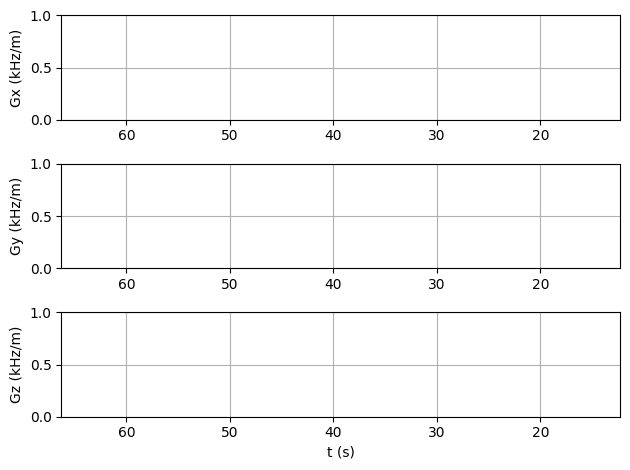

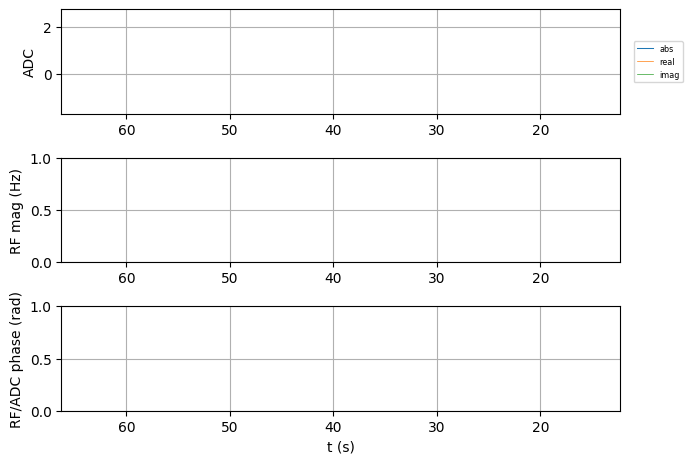

In [4]:
#@title 3D MTSE in a brain phantom - simulation
dB0 = 0
sz = [nRD, nPH, 1]
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
# (i) load a phantom object from file
if 0:
  obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
  obj_p = obj_p.interpolate(sz[0], sz[1], sz[2])
  # The default fov is loaded from the data, but we can change it:
  obj_p.size = torch.tensor([0.15,0.15,0.15])

  # Manipulate loaded data
  obj_p.T2dash[:] = 30e-3
  obj_p.D *= 0
  obj_p.B0 *= 0    # alter the B0 inhomogeneity
  # Store PD and B0 for comparison
  PD = obj_p.PD
  B0 = obj_p.B0
  # Manipulate loaded data
  obj_p.B0+=dB0
  obj_p.D*=0
  obj_p.plot()
else:
  obj_p = mr0.VoxelGridPhantom.load_mat('low_field_phantom.mat')
  obj_p.T2dash[:] = 30e-3
  obj_p.D *= 0

  #obj_p = obj_p.interpolate(40, 40, 16) # all slices
  obj_p = obj_p.interpolate(40, 40, 16).slices([6,7,8,9])  # reduced slices
  # The default fov is loaded from the data, but we can change it:
  obj_p.size = torch.tensor([0.15,0.15,0.15])

  # Store PD and B0 for comparison
  PD = obj_p.PD
  B0 = obj_p.B0
  # Manipulate loaded data
  #obj_p.B0*=1e-1

  obj_p.plot()


# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file('external.seq')
#seq0.plot_kspace_trajectory()
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
use_gpu=torch.cuda.is_available()
if use_gpu:
  signal = mr0.execute_graph(graph, seq0.cuda(), obj_p.cuda(),min_emitted_signal=0.05,min_latent_signal=0.05)
  signal=signal.cpu()
else:
  signal = mr0.execute_graph(graph, seq0, obj_p,min_emitted_signal=0.05,min_latent_signal=0.05)
# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

seq.plot(plot_now=False, time_range=(0, 0.36))
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


seq.plot(plot_now=False, time_range=(66.3, 66.36))
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


In [27]:
#@title Experimental Interactive seq.plot()
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive
from IPython.display import display
import ipywidgets as widgets

plt.ioff()  # Turn off interactive mode

def plot_sine(sec=0, t0=0,dt=1,full=False):
  if full:
    seq.plot(plot_now=False)
    mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
  else:
    seq.plot(plot_now=False, time_range=(sec+t0, sec+t0+dt))
    mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
  plt.show()

interactive_plot = interactive(plot_sine,full=True,
                               sec=widgets.IntSlider(min=0, max=100, step=1, value=6),
                               t0=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.29),
                               dt=widgets.FloatSlider(min=0, max=0.5, step=0.01, value=0.05))
display(interactive_plot)

interactive(children=(IntSlider(value=6, description='sec'), FloatSlider(value=0.29, description='t0', max=1.0…

In [6]:
#@title 3D MTSE in a brain phantom - reconstruction
# 3D FFT
def fft_3d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x, axes=(0, 1, 3)), axes=(0, 1, 3)), axes=(0, 1, 3))

kspace = np.reshape(signal, (n3D, nPH, n_echo, os*(nRD+nRD_pre+nRD_post)))
kspace = kspace[:,:,:,os*(nRD_pre):os*(nRD_pre+nRD)]
im = fft_3d(kspace)
im = im[:,:,:,round(os*nRD/2-nRD/2):round(os*nRD/2+nRD/2)]
fig = plt.figure(figsize=(8, 5))
plt.subplot(411)
plt.title('ADC signal')
plt.plot(np.real(signal), label='real')
plt.plot(np.imag(signal), label='imag')

slice=0
plt.figure()
plt.subplot(121)
plt.title('k-space')
plt.imshow(np.abs(kspace[slice,:,:,:].reshape(nPH,os*nRD*n_echo))); plt.axis('off');plt.colorbar()
plt.subplot(122)
plt.title('log. k-space')
plt.imshow(np.log(np.abs(kspace[slice,:,:,:].reshape(nPH,os*nRD*n_echo)))); plt.axis('off');plt.colorbar()
plt.figure()
plt.title('FFT-phase')
plt.imshow(np.angle(im[slice,:,:,:].reshape(nPH,nRD*n_echo)), vmin=-np.pi, vmax=np.pi, origin="lower"); plt.axis('off')
plt.colorbar()
plt.figure()
plt.title('FFT-mag.')
plt.imshow(np.abs(im[slice,:,:,:].reshape(nPH,nRD*n_echo)), origin="lower"); plt.axis('off');plt.colorbar()
plt.figure()
plt.title('phantom PD')
plt.imshow(PD.squeeze()[:,:,1].T, origin="lower"); plt.axis('off');plt.colorbar()

# Matlab Code for generating phantoms in MR-zero

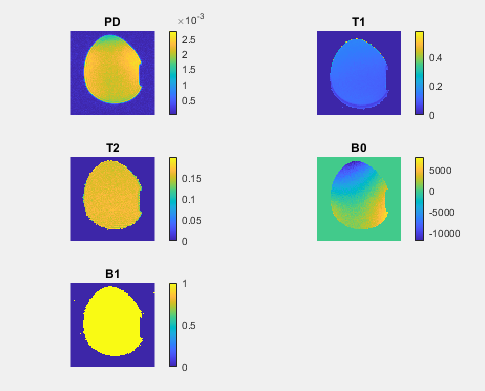

In [7]:
% generate cropped brain

clear

load  PD.mat
low_field_phantom(:,:,:,1)=permute(abs(image3D),[3,2,1]);  % PD in [a.u.]

low_field_phantom(:,:,:,5)=medfilt3(permute(abs(image3D)>0.00019,[3,2,1]));  % use simple mask for B1+ map;  rB1 in relative units

if 1  % use blurred mask for B1+ map to get realistic rB1 with 100% +- 20%
    low_field_phantom(:,:,:,5)=medfilt3(permute(abs(image3D),[3,2,1]));
    rB1=low_field_phantom(:,:,:,5);
    low_field_phantom(:,:,:,5)=rB1/mean(rB1(rB1>mean(rB1(:))));
end

load  T1.mat
low_field_phantom(:,:,:,2)=permute(t1map,[3,2,1])*1e-3;  % T1 in s

load  T2_CPMG.mat
low_field_phantom(:,:,:,3)=permute(t2map,[3,2,1])*1e-3;  % T2 in s

load  bo.mat
low_field_phantom(:,:,:,4)=permute(boMap,[3,2,1]);  % in T, i.e. to convert to Hz as we need it
low_field_phantom(:,:,:,4)=low_field_phantom(:,:,:,4)*42.5764*1e6; %requires multiplication with reduced gamma 42.5764 MHz /T

save('low_field_phantom.mat','low_field_phantom')


%%
titles={'PD','T1','T2','B0','B1'}; % this is the order expected by obj_p = mr0.VoxelGridPhantom.load_mat('low_field_phantom.mat')
figure,
for ii=1:5
    subplot(3,2,ii),
    img=squeeze(low_field_phantom(:,:,4,ii));
    imagesc(img); title(titles{ii}); colorbar; axis image; axis off;

end

SyntaxError: invalid syntax (<ipython-input-7-3d0e93a052d7>, line 5)